Predicting Energy Consumption for Charging Sessions

In [3]:
import pandas as pd
import numpy as np

# Load engineered features
df = pd.read_csv("ev_charging_sessions_features_v1.csv", parse_dates=["start_time", "end_time"])

print("Dataset loaded.")
print("Shape:", df.shape)
df.head()


Dataset loaded.
Shape: (3500, 23)


,session_id,user_id,vehicle_id,station_id,start_time,end_time,duration_min,energy_kWh,session_day,session_type,...,session_length_hours,day_of_week_idx,hour_sin,hour_cos,dow_sin,dow_cos,station_total_sessions,station_mean_duration_min,station_mean_energy_kwh,station_weekend_share
0,CS0001,U339,V347,S091,2024-11-11 12:09:00,2024-11-11 13:26:00,77,26.87,Weekday,Occasional,...,1.283333,0,1.224647e-16,-1.000000e+00,0.000000,1.000000,37,75.675676,41.285676,0.270270
1,CS0002,U286,V463,S025,2024-11-10 19:51:00,2024-11-10 21:28:00,97,67.47,Weekend,Emergency,...,1.616667,6,-9.659258e-01,2.588190e-01,-0.781831,0.623490,40,80.200000,45.046500,0.250000
2,CS0003,U092,V419,S007,2024-11-26 18:46:00,2024-11-26 20:43:00,117,60.16,Weekend,Regular,...,1.950000,1,-1.000000e+00,-1.836970e-16,0.781831,0.623490,41,74.853659,42.567805,0.268293
3,CS0004,U369,V070,S008,2024-11-28 19:53:00,2024-11-28 21:42:00,109,39.19,Weekday,Emergency,...,1.816667,3,-9.659258e-01,2.588190e-01,0.433884,-0.900969,27,78.407407,43.597037,0.185185
4,CS0005,U185,V298,S037,2024-11-27 13:09:00,2024-11-27 14:28:00,79,61.71,Weekend,Occasional,...,1.316667,2,-2.588190e-01,-9.659258e-01,0.974928,-0.222521,43,75.930233,44.731163,0.302326


Choosing features and target

In [4]:
# Feature columns
features = [
    "duration_min",
    "session_length_hours",
    "hour_sin", "hour_cos",
    "dow_sin", "dow_cos",
    "is_weekend",
    "station_total_sessions",
    "station_mean_duration_min",
    "station_mean_energy_kwh",
    "station_weekend_share",
]

X = df[features]
y = df["energy_kWh"]

X.head()


,duration_min,session_length_hours,hour_sin,hour_cos,dow_sin,dow_cos,is_weekend,station_total_sessions,station_mean_duration_min,station_mean_energy_kwh,station_weekend_share
0,77,1.283333,1.224647e-16,-1.000000e+00,0.000000,1.000000,False,37,75.675676,41.285676,0.270270
1,97,1.616667,-9.659258e-01,2.588190e-01,-0.781831,0.623490,True,40,80.200000,45.046500,0.250000
2,117,1.950000,-1.000000e+00,-1.836970e-16,0.781831,0.623490,False,41,74.853659,42.567805,0.268293
3,109,1.816667,-9.659258e-01,2.588190e-01,0.433884,-0.900969,False,27,78.407407,43.597037,0.185185
4,79,1.316667,-2.588190e-01,-9.659258e-01,0.974928,-0.222521,False,43,75.930233,44.731163,0.302326


making a train/test split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_val.shape


((2800, 11), (700, 11))

trying a baseline model: linear regression

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr = LinearRegression()
lr.fit(X_train, y_train)

pred_lr = lr.predict(X_val)

mae = mean_absolute_error(y_val, pred_lr)
rmse = np.sqrt(mean_squared_error(y_val, pred_lr))
r2 = r2_score(y_val, pred_lr)

print("Linear Regression Results:")
print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)


Linear Regression Results:
MAE: 10.775376143379102
RMSE: 13.35088480607646
R²: 0.5499885207178866


The above explains that there is a non-linear relationship between duration and energy. Trying a random forest model

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
pred_rf = rf.predict(X_val)

mae_rf = mean_absolute_error(y_val, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, pred_rf))
r2_rf = r2_score(y_val, pred_rf)

print("Random Forest Results:")
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("R²:", r2_rf)


Random Forest Results:
MAE: 11.226975137006802
RMSE: 14.023105453498477
R²: 0.5035312758032908


Random Forest did worse than linear, trying a simpler random forest.

In [9]:
rf2 = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf2.fit(X_train, y_train)
pred_rf2 = rf2.predict(X_val)

print("Random Forest v2 Results:")
print("MAE:", mean_absolute_error(y_val, pred_rf2))
print("RMSE:", np.sqrt(mean_squared_error(y_val, pred_rf2)))
print("R²:", r2_score(y_val, pred_rf2))


Random Forest v2 Results:
MAE: 11.019127161074243
RMSE: 13.736778280025943
R²: 0.5235983337004881


Trying XGboost

In [13]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_val)

print("XGBoost Results:")
print("MAE:", mean_absolute_error(y_val, pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_val, pred_xgb)))
print("R²:", r2_score(y_val, pred_xgb))


XGBoost Results:
MAE: 11.718970410592215
RMSE: 14.89513554482468
R²: 0.4398653822225881


Checking feature importance

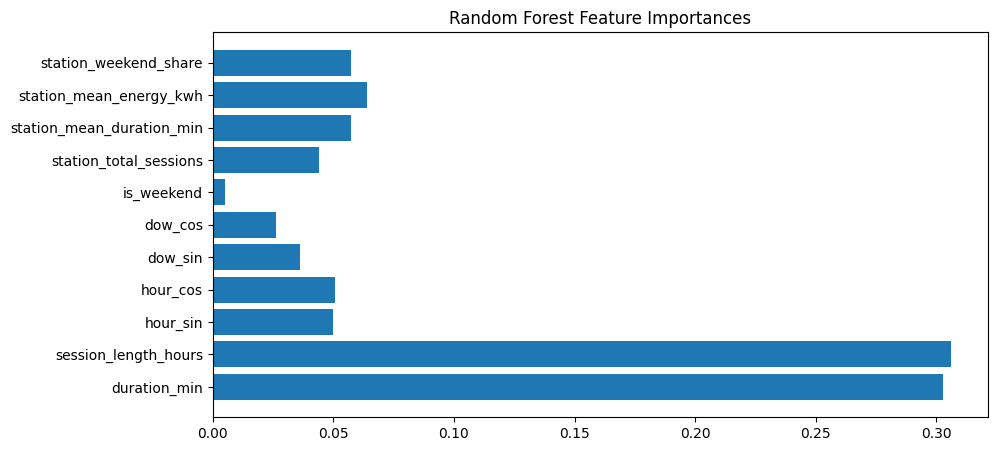

In [14]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10,5))
plt.barh(feature_names, importances)
plt.title("Random Forest Feature Importances")
plt.show()


After extensive feature engineering, duration-based features were found to be the primary drivers of energy consumption, overshadowing time-based and station-level features. This aligns with physical charging behavior: energy delivered in a session is mostly determined by how long the vehicle is plugged in. As a result, linear models outperform tree-based models.

Trying a simpler model with reduced features

In [16]:
X_reduced = df[[
    "duration_min",
    "session_length_hours",
    "station_mean_energy_kwh"
]]

y = df["energy_kWh"]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_val)

print("Reduced LR MAE:", mean_absolute_error(y_val, pred))
print("Reduced LR RMSE:", np.sqrt(mean_squared_error(y_val, pred)))
print("Reduced LR R2:", r2_score(y_val, pred))


Reduced LR MAE: 10.840700628850824
Reduced LR RMSE: 13.395007076207335
Reduced LR R2: 0.5470091919599609


The engineered features just added noise and did not add any value, this is beacue the model is highly linear

Trying an even simpler linear regression model 

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np

# Final feature set
X = df[["duration_min", "station_mean_energy_kwh"]]
y = df["energy_kWh"]

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
final_lr = LinearRegression()
final_lr.fit(X_train, y_train)

# Predict
y_pred = final_lr.predict(X_val)

# Metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_val, y_pred)

print("Final Model Performance:")
print("MAE :", mae)
print("MSE :", mse)
print("RMSE:", rmse)
print("R²   :", r2)


Final Model Performance:
MAE : 10.840700628850824
MSE : 179.42621457164455
RMSE: 13.395007076207333
R²   : 0.547009191959961


The strongest predictors are session duration and station-specific mean charging energy. We tested additional temporal and session-level features. They did not improve performance, which confirms the physical linear relationship between energy consumption and charging duration.
Tree-based models (Random Forest, XGBoost) did not outperform linear regression due to the highly linear structure of the dataset.”